In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath , groutine

In [2]:
crystal_thickness = 5

# Get the Crystal Geometries

In [3]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 10.
pre_length = 1e6

# Set up the pulse
FWHM = 50 # (um)

my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[1., 0., 0.],
                              sigma_x=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_y=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_z=2.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Set the crystal
# ----------------------------------------------------------------------------------------------------------
# Some meta data for the delay line.
h_length = 2. * np.pi / (0.89170 * 1e-4)

# Some crystal properties
chi0 = complex(-0.14606E-04, 0.12304E-07)
chih_sigma = complex(0.36477E-05, -0.11228E-07)
chihbar_sigma = chih_sigma
chih_pi = complex(0.12169E-06, -0.71046E-09)
chihbar_pi = chih_pi

# Bragg angle
bragg = np.radians(44.044) + 10e-6

# Get crystal angles
eta_b1 = np.zeros(1, dtype=np.float64)
theta_b1 = np.array([3 * np.pi / 2 - bragg,])
rho_b1 = theta_b1 + np.pi
tau_b1 = np.zeros(1)


# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=1,
                                           hlen=np.array([h_length, ]),
                                           theta=theta_b1,
                                           eta=eta_b1,
                                           rho=rho_b1,
                                           tau=tau_b1,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)
crystal_list_1[0].set_thickness(crystal_thickness)

# Rotate the Crystals

In [4]:
# Get kout
kout_c = util.get_bragg_kout(kin = my_pulse.k0, 
                             h=crystal_list_1[0].h,
                             normal=crystal_list_1[0].normal)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observation = kout_c * 1e6 / util.l2_norm(kout_c)
total_path = pre_length + 1e6
print("The total propagation length is {:.2f}m.".format(total_path / 1e6))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Change frame
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# find the rotation matrix to find the proper frame
tmp = np.arctan(kout_c[1] / kout_c[2])
rot_tmp = Rotation.from_euler('x', tmp)

(my_pulse,
 observation,
 [crystal_list_1,]
) = lclsutil.get_intermediate_frame(displacement=np.zeros(3),
                                    rotation= rot_tmp.as_dcm(),
                                    observe=observation,
                                    pulse=my_pulse,
                                    crystal_lists = [crystal_list_1,])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 800
number_z = 10 ** 5
kx_grid, ky_grid, kz_grid, axis_info = util.get_k_mesh_3d(number_x=number_x,
                                                          number_y=number_y,
                                                          number_z=number_z,
                                                          delta_e_x=1e-50,
                                                          delta_e_y=5e-4,
                                                          delta_e_z=2e-3)
kz_grid += my_pulse.klen0

# Apply fft shift
# kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

The total propagation length is 2.00m.


# Get the output field

In [5]:
# Set the range of the index to save
z_idx_range = 400
num1 = 350
num2 = 50
d_num = 512

crystal_list = crystal_list_1

# -------------------------------------------------------------
#            Get Field for variable branch
# -------------------------------------------------------------
tic = time.time()

(result_3d_var,
 result_2d_var,
 check_var
) = groutine.get_diffraction_field(crystal_list = crystal_list,
                                   total_path = total_path, 
                                   observation = observation,
                                   my_pulse = my_pulse,
                                   kx_grid = kx_grid,
                                   ky_grid = ky_grid,
                                   kz_grid = kz_grid,
                                   pulse_delay_time = 0.,
                                   pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                   grating_orders = [0,],
                                   number_x = number_x,
                                   number_y = number_y,
                                   number_z = number_z,
                                   z_idx_range = z_idx_range,
                                   idx_start_1=number_z - num1,
                                   idx_start_2=0,
                                   num1 = num1,
                                   num2 = num2, 
                                   d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.06 seconds to prepare the variables.
It takes 19.33 seconds to get the field for branch 1.


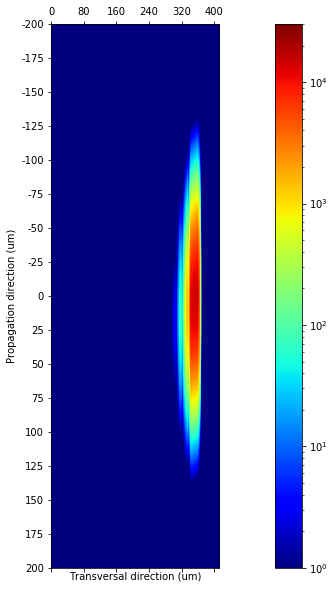

In [6]:
from pylab import figure, cm
from matplotlib.colors import LogNorm

yposition = np.arange(-200, 201, 25)
yticks = yposition / (axis_info['y_idx'][1] - axis_info['y_idx'][0]) + 200

xposition = np.arange(0, 401, 80)
xticks = xposition / (axis_info['z_time_idx'][1] - axis_info['z_time_idx'][0])

# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(20)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_fix = np.roll(np.fft.ifftshift(np.fft.ifft(result_2d_var['x_field_2d'], axis=0), axes=0),
                   shift=0, axis=0)

im = axes.matshow(2 * np.abs(field_fix)[200:600,:],
                  cmap='jet',
                  norm=LogNorm(vmin=1e0, vmax=3e4),
                  aspect=4)

#axes.set_title("Time response for R0H")
axes.set_yticks(yticks)
axes.set_yticklabels(yposition)
axes.set_xticks(xticks)
axes.set_xticklabels(xposition)

axes.set_ylabel("Propagation direction (um)")
axes.set_xlabel("Transversal direction (um)")
fig.colorbar(im, ax=axes )#, format='$%.2f$')
# Show the canvas

plt.show()

In [7]:
from pylab import figure, cm
from matplotlib.colors import LogNorm

yposition = np.arange(-200, 201, 25)
yticks = yposition / (axis_info['y_idx'][1] - axis_info['y_idx'][0]) + 200

xposition = np.arange(0, 125, 25)
xticks = xposition / (axis_info['z_idx'][1] - axis_info['z_idx'][0])

# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)

fig.set_figheight(10)
fig.set_figwidth(20)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_fix = np.roll(np.fft.ifftshift(np.fft.ifft(result_2d_var['x_field_2d'], axis=0), axes=0),
                   shift=0, axis=0)

im = axes.matshow(np.square(np.abs(field_fix)[200:600,:]),
                  cmap='jet',
                  norm=LogNorm(vmin=1e0, vmax=1e8),
                  aspect=4)

#axes.set_title("Time response for R0H")
axes.set_yticks(yticks)
axes.set_yticklabels(yposition)
axes.set_xticks(xticks)
axes.set_xticklabels(xposition)

axes.set_ylabel("Transversal direction (um)")
axes.set_xlabel("Propagation direction (um)")
fig.colorbar(im, ax=axes )#, format='$%.2f$')
# Show the canvas
#plt.axis('off')

#fig.savefig('C:/Users/haoyuan/Desktop/sigma_5um.png', bbox_inches='tight', pad_inches=0, dpi=600)

fig.savefig('C:/Users/haoyuan/Desktop/sigma_{}um.png'.format(crystal_thickness),
            bbox_inches='tight', pad_inches=0, dpi=600)
plt.close()